In [1]:
import pyarrow # Please note that you need to install `pyarrow` (`pip install pyarrow`) to use Parquet IO functionalities.
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler

# Explore the Dimension Reduction Features

In [2]:
df = pd.read_parquet("../data/3-recommendations_100000_samples-train_preprocessed.parquet")
df.head(1)

,helpful,funny,date,is_recommended,hours,date_release,win,mac,linux,rating,...,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,tSNE_1,tSNE_2,UMAP_1,UMAP_2
0,0,0,1669593600000000000,1,36.6,1537401600000000000,1,0,0,7,...,-0.005346,-0.014631,0.00576,-0.036982,0.004737,0.02002,-0.535025,-2.667907,12.603759,-1.406423


In [3]:
df.shape

(80000, 471)

In [4]:
df.columns

Index(['helpful', 'funny', 'date', 'is_recommended', 'hours', 'date_release',
       'win', 'mac', 'linux', 'rating',
       ...
       'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'tSNE_1',
       'tSNE_2', 'UMAP_1', 'UMAP_2'],
      dtype='object', length=471)

In [5]:
tag_columns = [c for c in df.columns if c.startswith("tag_")]
print(len(tag_columns))

439


In [6]:
pca_columns = [c for c in df.columns if c.startswith("PCA_")]
tsne_columns = [c for c in df.columns if c.startswith("tSNE_")]
umap_columns = [c for c in df.columns if c.startswith("UMAP_")]
print(
    len(pca_columns),
    len(tsne_columns),
    len(umap_columns)
)

10 2 2


In [7]:
df_nontags = df[[c for c in df.columns if c not in tag_columns+pca_columns+tsne_columns+umap_columns]]
df_nontags.shape

(80000, 18)

In [8]:
# Keep only the first two principal components
dimension_reduction_columns = pca_columns[:2] + tsne_columns + umap_columns
dimension_reduction_df = df[dimension_reduction_columns]
dimension_reduction_df

,PCA_1,PCA_2,tSNE_1,tSNE_2,UMAP_1,UMAP_2
0,-0.998578,-0.064917,-0.535025,-2.667907,12.603759,-1.406423
1,0.738559,-1.838622,-2.801814,-21.124817,7.404410,-15.379845
2,1.073333,2.014300,-2.703941,17.757954,0.276401,6.479164
3,-0.998578,-0.064917,-0.535075,-2.667866,12.487345,-1.437277
4,-0.998578,-0.064917,-0.535094,-2.667852,13.148644,-0.278025
...,...,...,...,...,...,...
79995,0.579811,0.969813,-13.639039,7.742299,4.103660,8.027107
79996,1.569493,-1.903562,1.103803,-18.897194,19.425604,9.839744
79997,-0.998578,-0.064917,-0.534914,-2.667967,14.191500,-0.599660
79998,-0.998578,-0.064917,-0.534914,-2.667967,12.413139,0.311503


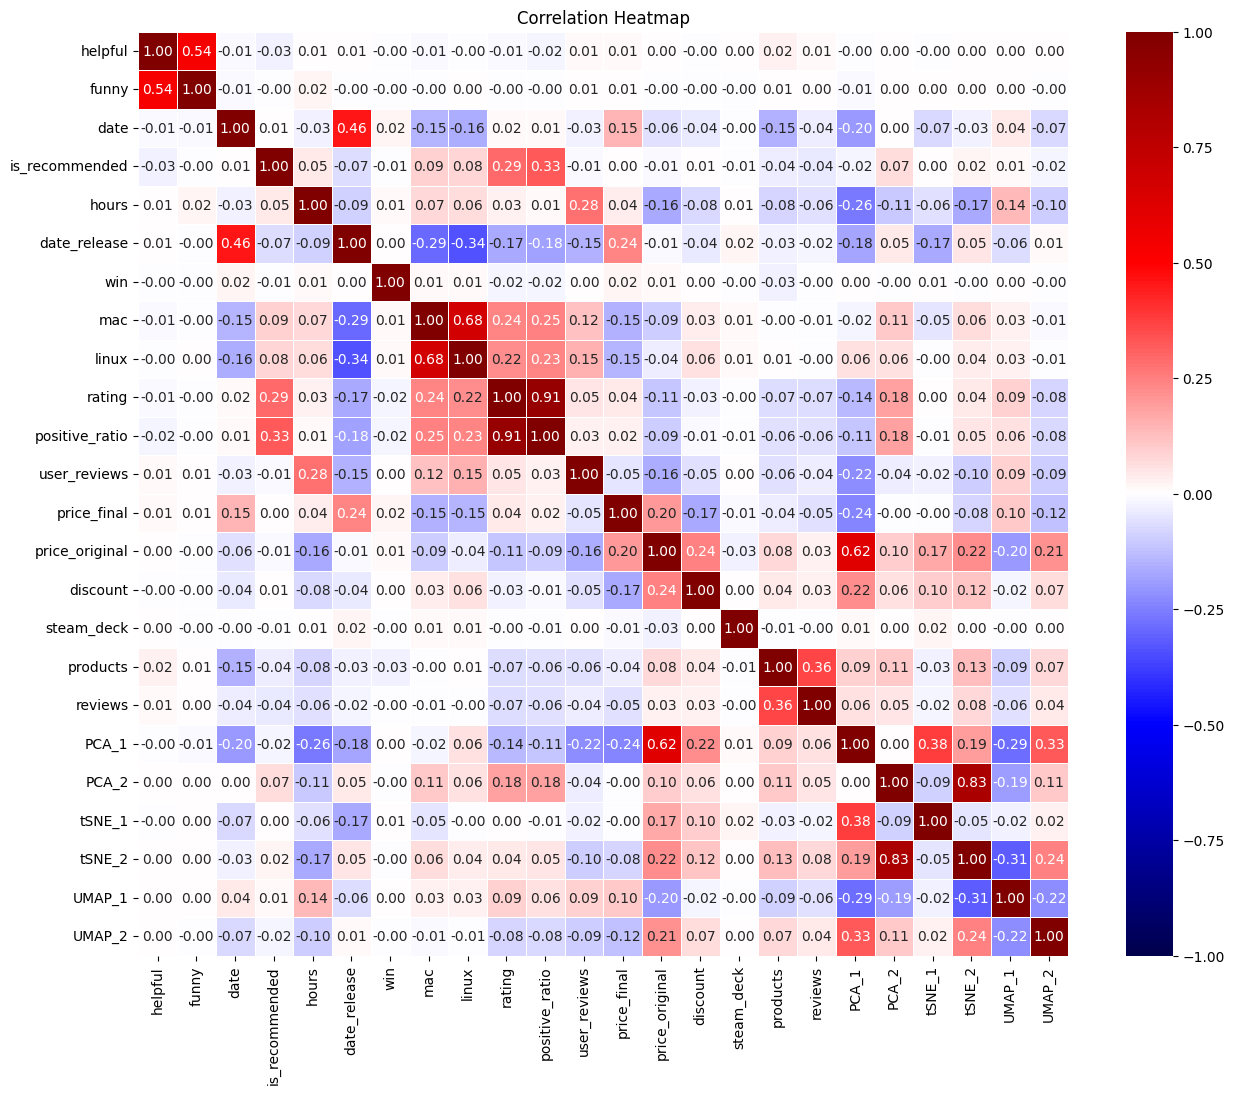

In [9]:
corr_matrix = pd.concat([df_nontags, dimension_reduction_df], axis=1).corr()

plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='seismic', 
    fmt=".2f", 
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title('Correlation Heatmap')
plt.show()


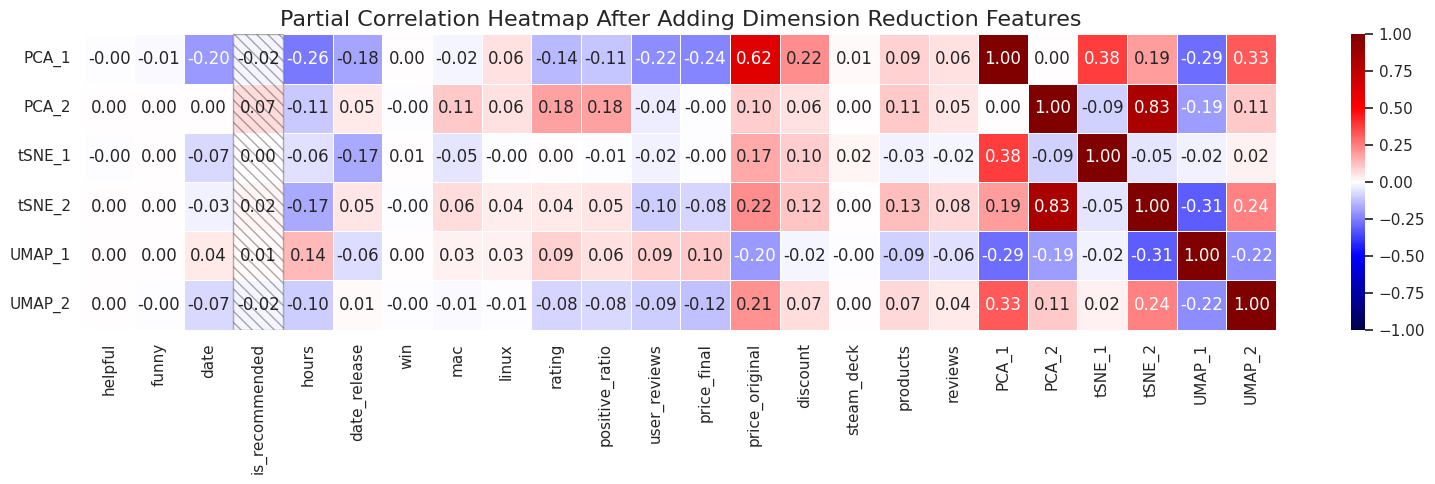

In [52]:
# Truncate the heatmap to show only the last 6 rows of the correlation matrix
corr_matrix_truncated = corr_matrix[-6:]

plt.figure(figsize=(16, 5))
sns.heatmap(
    corr_matrix_truncated, 
    annot=True, 
    cmap='seismic', 
    fmt=".2f", 
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title('Partial Correlation Heatmap After Adding Dimension Reduction Features', fontsize=16)
# plt.xticks(rotation=45) 
plt.yticks(rotation=0) 


import matplotlib.patches as patches
# Highlight the specific column with a rectangle using dashed lines and reduced opacity
highlighted_column_index = corr_matrix_truncated.columns.get_loc("is_recommended")
rect = patches.Rectangle(
    (highlighted_column_index, 0), 1, len(corr_matrix_truncated), 
    linewidth=1, 
    edgecolor='black', 
    facecolor='none', 
    hatch='\\\\\\', 
    alpha=0.33, 
    zorder=3
)
plt.gca().add_patch(rect)

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.savefig("../data/2-plot/DimensionReduction-1-Partial_Correlation_Heatmap.png") 
plt.show()


In [11]:
# Keep only the first two principal components
df_pca = pd.concat([df_nontags, dimension_reduction_df[pca_columns[:2]]], axis=1)
df_pca

,helpful,funny,date,is_recommended,hours,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,products,reviews,PCA_1,PCA_2
0,0,0,1669593600000000000,1,36.6,1537401600000000000,1,0,0,7,89,36370,15.00,0.00,0.0,1,34,2,-0.998578,-0.064917
1,0,0,1649116800000000000,1,41.6,1670630400000000000,1,0,0,4,54,49594,0.00,0.00,0.0,1,32,6,0.738559,-1.838622
2,0,0,1533859200000000000,1,1.0,1473897600000000000,1,0,0,7,94,4925,0.00,0.00,0.0,1,102,2,1.073333,2.014300
3,0,0,1655683200000000000,1,85.2,1383868800000000000,1,1,1,7,94,173263,20.00,0.00,0.0,1,12,1,-0.998578,-0.064917
4,0,0,1669334400000000000,1,92.5,1654992000000000000,1,0,0,7,82,23960,40.00,0.00,0.0,1,339,4,-0.998578,-0.064917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,2,0,1606348800000000000,1,13.8,1583452800000000000,1,1,0,7,85,6611,19.99,19.99,0.0,1,72,7,0.579811,0.969813
79996,2,0,1622937600000000000,1,30.6,1533772800000000000,1,0,0,7,80,14626,29.99,29.99,0.0,1,50,9,1.569493,-1.903562
79997,0,0,1639180800000000000,1,8.0,1516838400000000000,1,1,1,8,97,72238,20.00,0.00,0.0,1,268,9,-0.998578,-0.064917
79998,0,0,1661212800000000000,1,43.9,1507507200000000000,1,0,0,7,88,67261,50.00,0.00,0.0,1,66,1,-0.998578,-0.064917


In [12]:
df_tsne = pd.concat([df_nontags, dimension_reduction_df[tsne_columns]], axis=1)
df_tsne

,helpful,funny,date,is_recommended,hours,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,products,reviews,tSNE_1,tSNE_2
0,0,0,1669593600000000000,1,36.6,1537401600000000000,1,0,0,7,89,36370,15.00,0.00,0.0,1,34,2,-0.535025,-2.667907
1,0,0,1649116800000000000,1,41.6,1670630400000000000,1,0,0,4,54,49594,0.00,0.00,0.0,1,32,6,-2.801814,-21.124817
2,0,0,1533859200000000000,1,1.0,1473897600000000000,1,0,0,7,94,4925,0.00,0.00,0.0,1,102,2,-2.703941,17.757954
3,0,0,1655683200000000000,1,85.2,1383868800000000000,1,1,1,7,94,173263,20.00,0.00,0.0,1,12,1,-0.535075,-2.667866
4,0,0,1669334400000000000,1,92.5,1654992000000000000,1,0,0,7,82,23960,40.00,0.00,0.0,1,339,4,-0.535094,-2.667852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,2,0,1606348800000000000,1,13.8,1583452800000000000,1,1,0,7,85,6611,19.99,19.99,0.0,1,72,7,-13.639039,7.742299
79996,2,0,1622937600000000000,1,30.6,1533772800000000000,1,0,0,7,80,14626,29.99,29.99,0.0,1,50,9,1.103803,-18.897194
79997,0,0,1639180800000000000,1,8.0,1516838400000000000,1,1,1,8,97,72238,20.00,0.00,0.0,1,268,9,-0.534914,-2.667967
79998,0,0,1661212800000000000,1,43.9,1507507200000000000,1,0,0,7,88,67261,50.00,0.00,0.0,1,66,1,-0.534914,-2.667967


In [13]:
df_umap = pd.concat([df_nontags, dimension_reduction_df[umap_columns]], axis=1)
df_umap

,helpful,funny,date,is_recommended,hours,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,products,reviews,UMAP_1,UMAP_2
0,0,0,1669593600000000000,1,36.6,1537401600000000000,1,0,0,7,89,36370,15.00,0.00,0.0,1,34,2,12.603759,-1.406423
1,0,0,1649116800000000000,1,41.6,1670630400000000000,1,0,0,4,54,49594,0.00,0.00,0.0,1,32,6,7.404410,-15.379845
2,0,0,1533859200000000000,1,1.0,1473897600000000000,1,0,0,7,94,4925,0.00,0.00,0.0,1,102,2,0.276401,6.479164
3,0,0,1655683200000000000,1,85.2,1383868800000000000,1,1,1,7,94,173263,20.00,0.00,0.0,1,12,1,12.487345,-1.437277
4,0,0,1669334400000000000,1,92.5,1654992000000000000,1,0,0,7,82,23960,40.00,0.00,0.0,1,339,4,13.148644,-0.278025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,2,0,1606348800000000000,1,13.8,1583452800000000000,1,1,0,7,85,6611,19.99,19.99,0.0,1,72,7,4.103660,8.027107
79996,2,0,1622937600000000000,1,30.6,1533772800000000000,1,0,0,7,80,14626,29.99,29.99,0.0,1,50,9,19.425604,9.839744
79997,0,0,1639180800000000000,1,8.0,1516838400000000000,1,1,1,8,97,72238,20.00,0.00,0.0,1,268,9,14.191500,-0.599660
79998,0,0,1661212800000000000,1,43.9,1507507200000000000,1,0,0,7,88,67261,50.00,0.00,0.0,1,66,1,12.413139,0.311503


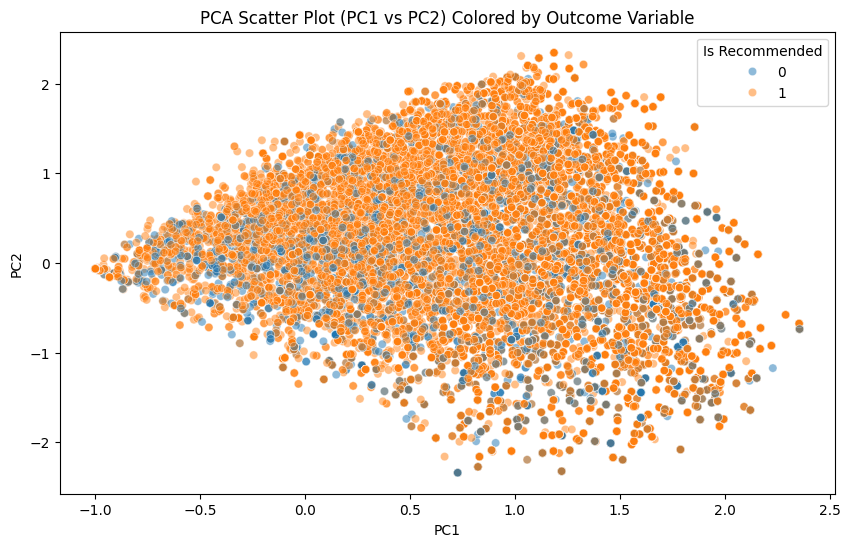

In [14]:
# Plot the scatter plot with hue by outcome variable
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PCA_1', y='PCA_2', hue='is_recommended', alpha=0.5)
plt.title('PCA Scatter Plot (PC1 vs PC2) Colored by Outcome Variable')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Is Recommended')
plt.show()

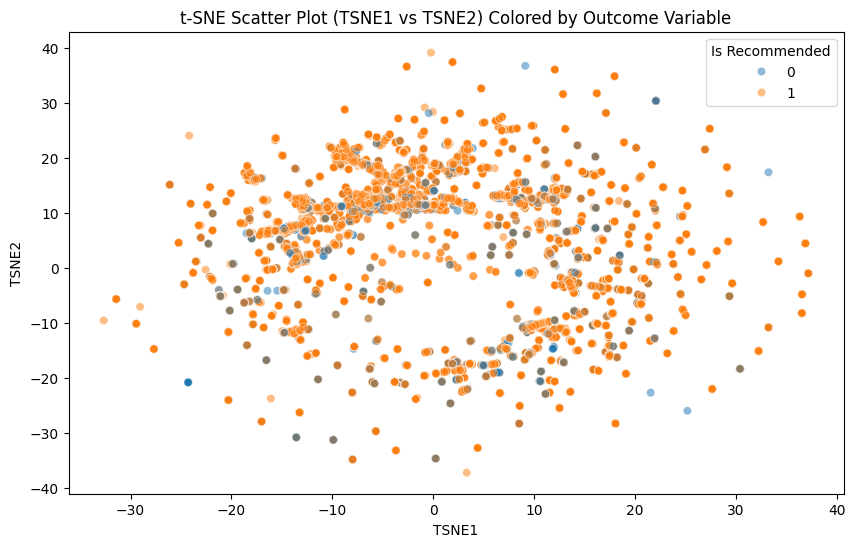

In [15]:
# Plot the scatter plot with hue by outcome variable
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x='tSNE_1', y='tSNE_2', hue='is_recommended', alpha=0.5)
plt.title('t-SNE Scatter Plot (TSNE1 vs TSNE2) Colored by Outcome Variable')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(title='Is Recommended')
plt.show()

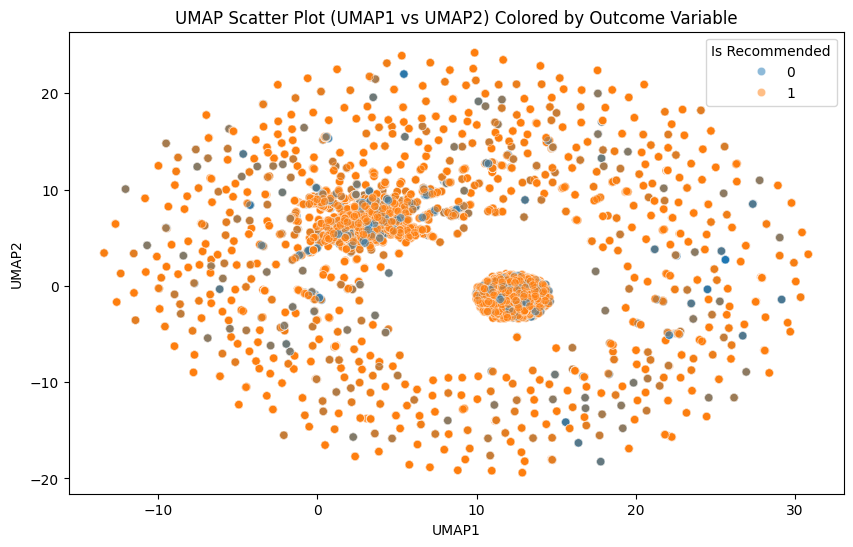

In [16]:
# Plot the scatter plot with hue by outcome variable
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP_1', y='UMAP_2', hue='is_recommended', alpha=0.5)
plt.title('UMAP Scatter Plot (UMAP1 vs UMAP2) Colored by Outcome Variable')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Is Recommended')
plt.show()

# Data Loading

In [17]:
df_train = pd.read_parquet("../data/3-recommendations_100000_samples-train_preprocessed.parquet")
df_train.shape

(80000, 471)

In [18]:
df_test = pd.read_parquet("../data/3-recommendations_100000_samples-test_preprocessed.parquet")
df_test.shape

(20000, 471)

In [19]:
# I conducted several experiments including:
# 1. Excluding all tag features and their dimension-reduced counterparts.
# 2. Using only the PCA columns of tag features.
# 3. Using only the t-SNE columns of tag features.
# 4. Using only the UMAP columns of tag features.
# There were almost no differences observed.
X_train = df_train[[
    c for c in df_train 
    if c != "is_recommended"
    and not c.startswith("tag_")
    and not c.startswith("PCA_")
    and not c.startswith("tSNE_")
    and not c.startswith("UMAP_")
]]
y_train = df_train["is_recommended"]
print(f"{X_train.shape=} {y_train.shape=}")
X_test = df_test[[
    c for c in df_test 
    if c != "is_recommended"
    and not c.startswith("tag_")
    and not c.startswith("PCA_")
    and not c.startswith("tSNE_")
    and not c.startswith("UMAP_")
]]
y_test = df_test["is_recommended"]
print(f"{X_test.shape=} {y_test.shape=}")

X_train.shape=(80000, 17) y_train.shape=(80000,)
X_test.shape=(20000, 17) y_test.shape=(20000,)


In [20]:
# scaler = StandardScaler()
# we use MinMaxScaler here, because MinMaxScaler ensures that all features contribute equally to the distance computation.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN

In [21]:
# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': list(range(1, 51, 1)),          # 35
    # 'weights': ['uniform', 'distance'],          # 'uniform'
    'metric': ['euclidean', 'manhattan'],        # 'manhattan'
}

In [22]:
# Perform grid search with cross-validation to find the best parameters
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [23]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 35}


In [24]:
# Train the KNN classifier using the best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=35)

## Evaluate the classifier using various metrics

In [25]:
def evaluate_model(model, X_test, y_test):
    evaluation_results = {}

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n {conf_matrix}")
    evaluation_results["confusion_matrix"] = conf_matrix.tolist()
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    evaluation_results["accuracy"] = accuracy
    
    # Precision
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)
    evaluation_results["precision"] = precision
    
    # Recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)
    evaluation_results["recall"] = recall
    
    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)
    evaluation_results["f1_score"] = f1
    
    # ROC Curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    roc_curve_data = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}
    evaluation_results["roc_curve"] = roc_curve_data
    
    # Precision-Recall Curve and Average Precision
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    average_precision = average_precision_score(y_test, y_proba)
    
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

    pr_curve = {"precision": precision.tolist(), "recall": recall.tolist(), "average_precision": average_precision}
    evaluation_results["precision_recall_curve"] = pr_curve

    return evaluation_results


Confusion Matrix: 
 [[  319  2683]
 [  167 16831]]
Accuracy: 0.8575
Precision: 0.8625089679204674
Recall: 0.990175314742911
F1 Score: 0.9219434706397897


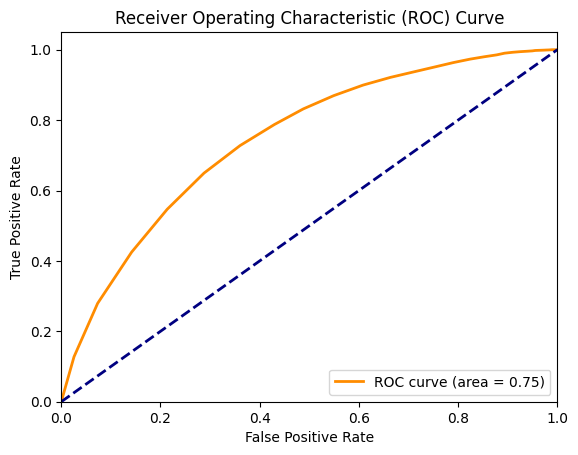

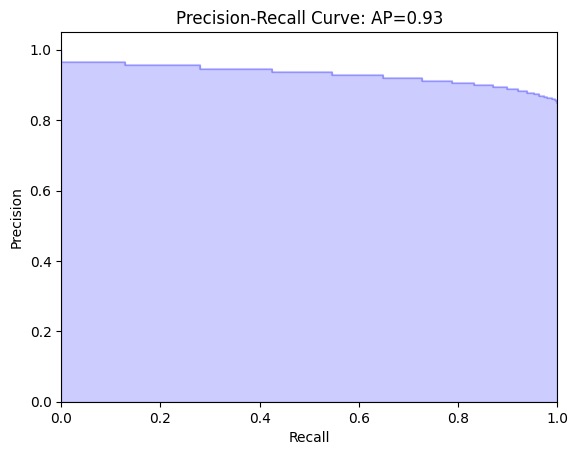

In [26]:
best_knn_evaluation_results = evaluate_model(best_knn, X_test, y_test)

In [27]:
print(best_knn_evaluation_results)

{'confusion_matrix': [[319, 2683], [167, 16831]], 'accuracy': 0.8575, 'precision': 0.8625089679204674, 'recall': 0.990175314742911, 'f1_score': 0.9219434706397897, 'roc_curve': {'fpr': [0.0, 0.025649566955363093, 0.07328447701532312, 0.1419053964023984, 0.21352431712191872, 0.28780812791472354, 0.36042638241172553, 0.4297135243171219, 0.4880079946702199, 0.5493004663557628, 0.6085942704863424, 0.6635576282478348, 0.7145236508994004, 0.7568287808127915, 0.790473017988008, 0.8241172551632245, 0.8527648234510327, 0.8780812791472352, 0.8937375083277814, 0.9103930712858095, 0.9257161892071952, 0.9393737508327782, 0.9497001998667555, 0.955363091272485, 0.960692871419054, 0.9680213191205863, 0.9733510992671552, 0.9776815456362425, 0.9823451032644903, 0.9843437708194537, 0.986342438374417, 0.9876748834110592, 0.9900066622251832, 0.9910059960026649, 0.9936708860759493, 0.9993337774816788, 1.0], 'tpr': [0.0, 0.12754441699023414, 0.2794446405459466, 0.4251088363336863, 0.546711377809154, 0.649547

In [28]:
# Save results to a JSON file
with open("../data/4-best_knn_evaluation_results.json", "w") as json_file:
    json.dump(best_knn_evaluation_results, json_file, indent=4)

# Mean Cross-Validation Score for Different Parameter Settings

In [36]:
param_grid.items()

dict_items([('n_neighbors', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]), ('metric', ['euclidean', 'manhattan'])])

In [37]:
grid_search.cv_results_['mean_test_score']

array([0.8017875, 0.7470875, 0.83935  , 0.8203375, 0.8517   , 0.8415   ,
       0.85605  , 0.8507625, 0.859325 , 0.855325 , 0.860775 , 0.8583875,
       0.8619   , 0.8599375, 0.8627125, 0.8610125, 0.86295  , 0.8621625,
       0.8631   , 0.86205  , 0.8636875, 0.8627375, 0.86385  , 0.8629375,
       0.864    , 0.8632125, 0.8639875, 0.8634375, 0.8641625, 0.8634   ,
       0.8637125, 0.8631625, 0.8638875, 0.86345  , 0.8639875, 0.863475 ,
       0.8637625, 0.863425 , 0.864125 , 0.8635125, 0.863975 , 0.86375  ,
       0.864    , 0.8638   , 0.8639625, 0.8638125, 0.863775 , 0.86355  ,
       0.86395  , 0.863775 , 0.8039625, 0.750025 , 0.840475 , 0.82095  ,
       0.852275 , 0.84255  , 0.8574125, 0.85225  , 0.8599375, 0.8562375,
       0.8613875, 0.8582875, 0.8623875, 0.860275 , 0.8633875, 0.8619125,
       0.8634125, 0.86195  , 0.863375 , 0.8623875, 0.863175 , 0.862525 ,
       0.8636375, 0.862975 , 0.8640375, 0.8629   , 0.8638   , 0.8634625,
       0.8639625, 0.8633625, 0.864025 , 0.86395  , 

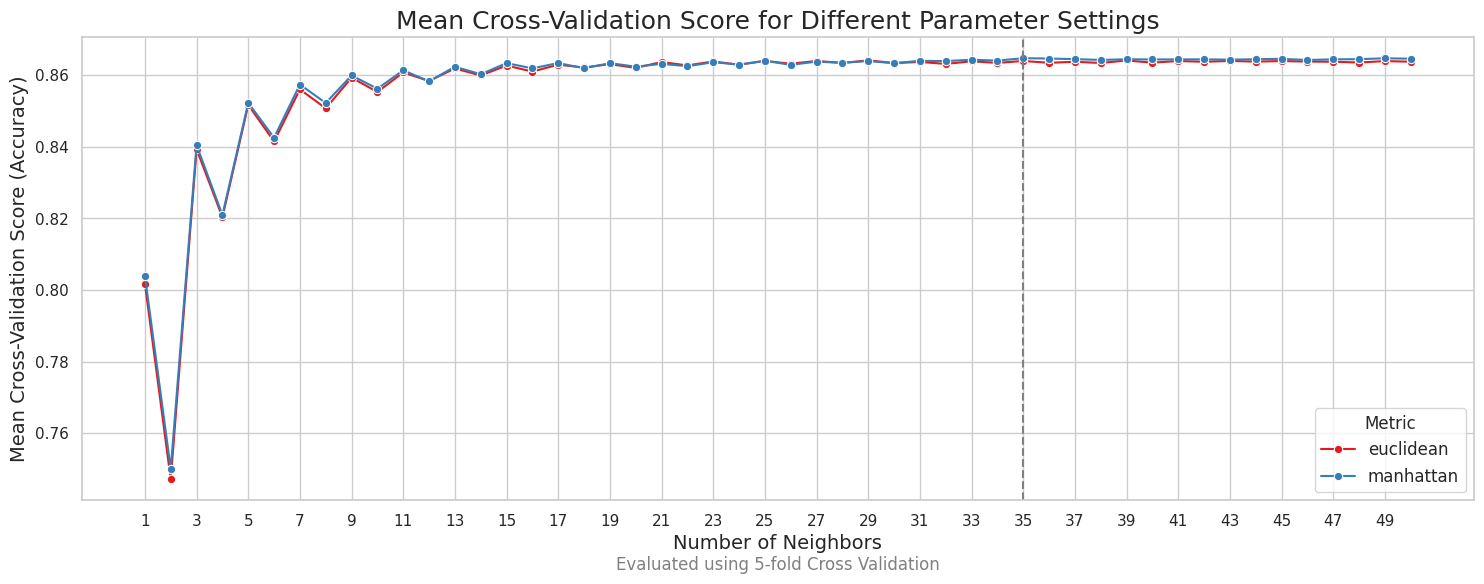

In [50]:
# Get the results of grid search
results = grid_search.cv_results_

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting the accuracy change for each parameter setting
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(
    data=results_df, 
    x='param_n_neighbors', 
    y='mean_test_score', 
    hue='param_metric', 
    palette='Set1', 
    marker='o',
)
plt.title("Mean Cross-Validation Score for Different Parameter Settings", fontsize=18)
plt.xlabel("Number of Neighbors", fontsize=14)
plt.ylabel("Mean Cross-Validation Score (Accuracy)", fontsize=14)
plt.legend(title='Metric', fontsize=12, loc='lower right')
plt.xticks(list(range(1, 51, 2)))
# plt.ylim(0, 1) 

# Highlight x=35
plt.axvline(x=35, color='grey', linestyle='--', label='x=35')
plt.annotate('Evaluated using 5-fold Cross Validation', 
             xy=(0.5, -0.15), 
             xycoords='axes fraction', 
             ha='center', 
             fontsize=12, 
             color='gray')

plt.tight_layout()
plt.savefig("../data/4-KNN-Mean Cross-Validation Score for Different Parameter Settings.png")
plt.show()